# Time series forecasting using xgboost now

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('tesla_stock_data.csv')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
# df = df.sort_index()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-12-19,451.88,456.36,420.02,436.17,436.17,"117,896,400"
2024-12-18,466.50,488.54,427.01,440.13,440.13,"149,340,800"
2024-12-17,475.90,483.99,457.51,479.86,479.86,"131,223,000"
2024-12-16,441.09,463.19,436.15,463.02,463.02,"114,083,800"
2024-12-13,420.00,436.30,415.71,436.23,436.23,"89,000,200"


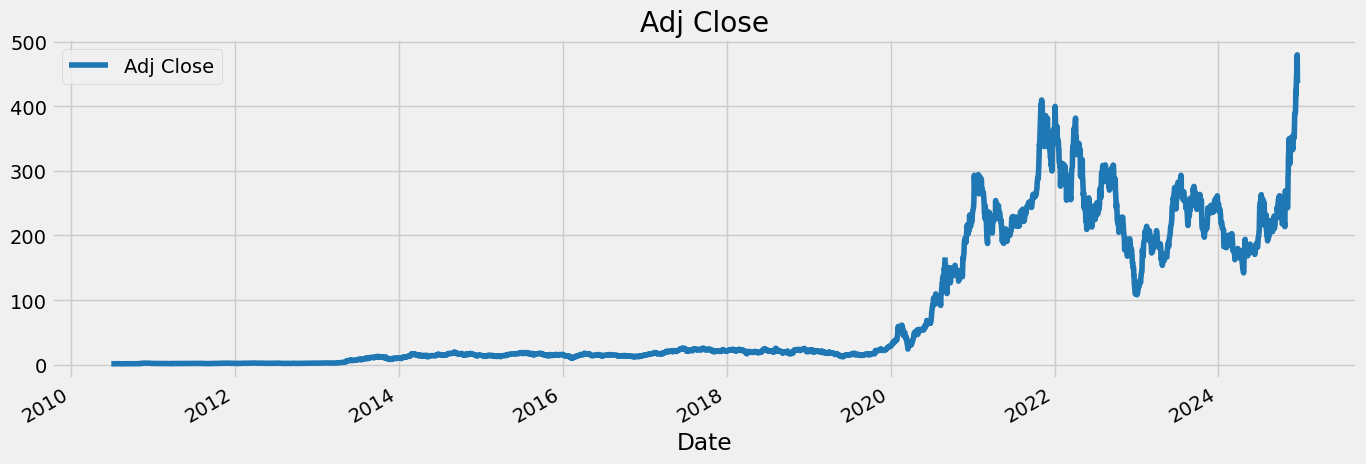

In [3]:
df['Adj Close'].plot(figsize=(15,5),
                     color = color_pal[0],
                     title='Adj Close')
plt.legend()
plt.show()

### df/Test Split

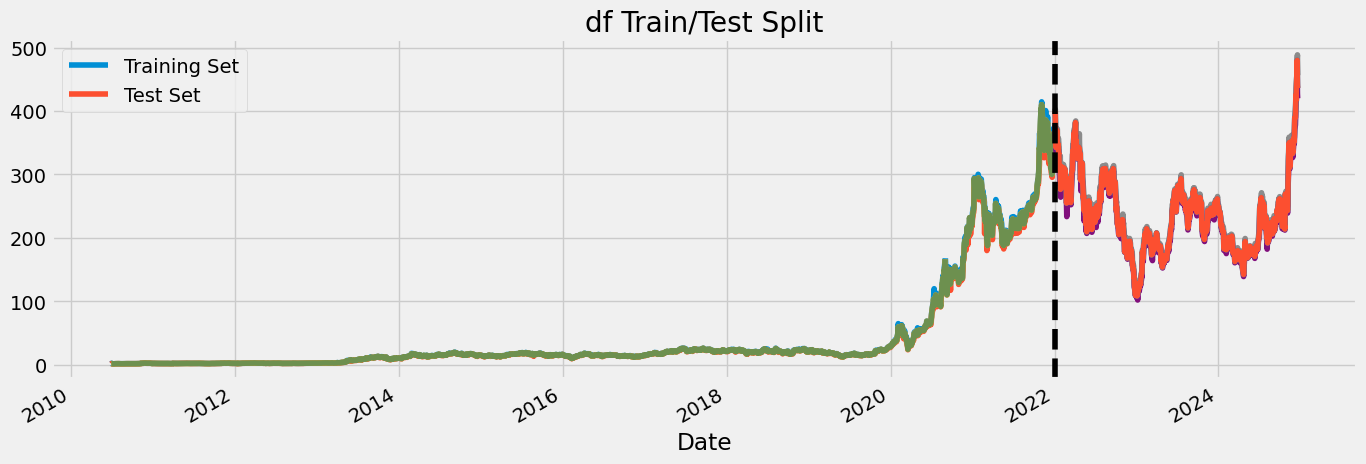

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-31,357.81,360.67,351.53,352.26,352.26,"40,733,700"
2021-12-30,353.78,365.18,351.05,356.78,356.78,"47,040,900"
2021-12-29,366.21,368.00,354.71,362.06,362.06,"56,154,000"
2021-12-28,369.83,373.00,359.47,362.82,362.82,"60,324,000"
2021-12-27,357.89,372.33,356.91,364.65,364.65,"71,145,900"


In [4]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='df Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

train.head()

In [5]:
print(df['Adj Close'].head(10))
print(df['Adj Close'].dtype)  # Check the df type
print(df['Adj Close'].isna().sum())  # Count missing values
print(df['Adj Close'].describe())  # Basic statistics


Date
2024-12-19    436.17
2024-12-18    440.13
2024-12-17    479.86
2024-12-16    463.02
2024-12-13    436.23
2024-12-12    418.10
2024-12-11    424.77
2024-12-10    400.99
2024-12-09    389.79
2024-12-06    389.22
Name: Adj Close, dtype: float64
float64
2
count    3645.000000
mean       80.852255
std       106.619257
min         1.050000
25%        12.090000
50%        17.860000
75%       177.550000
max       479.860000
Name: Adj Close, dtype: float64


### Feature Engineering

C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_5'] = df['Adj Close'].pct_change(periods=5)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_20'] = df['Adj Close'].pct_change(periods=20)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_me

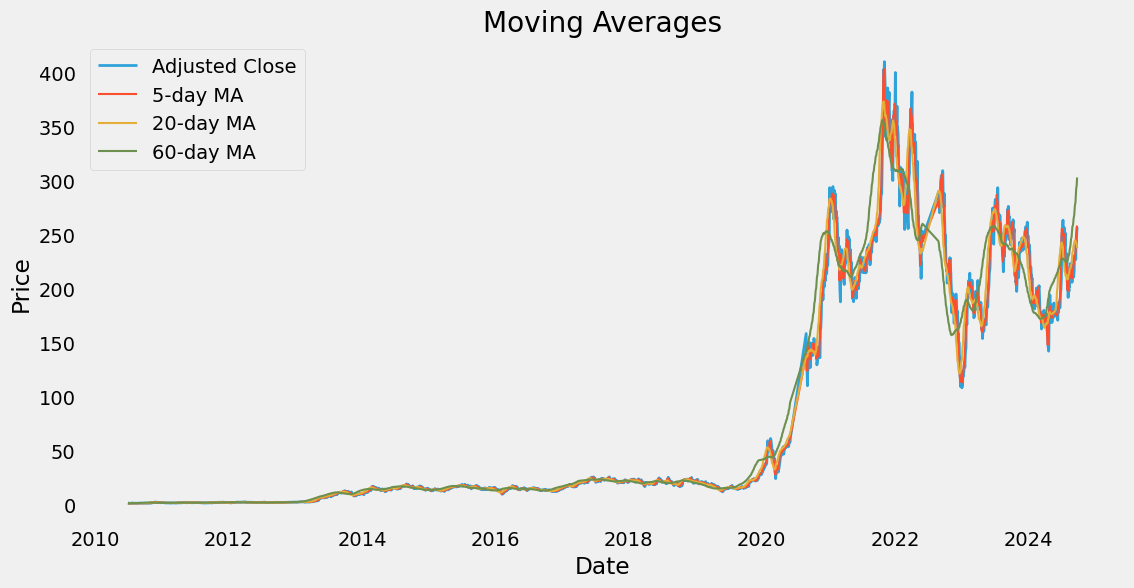

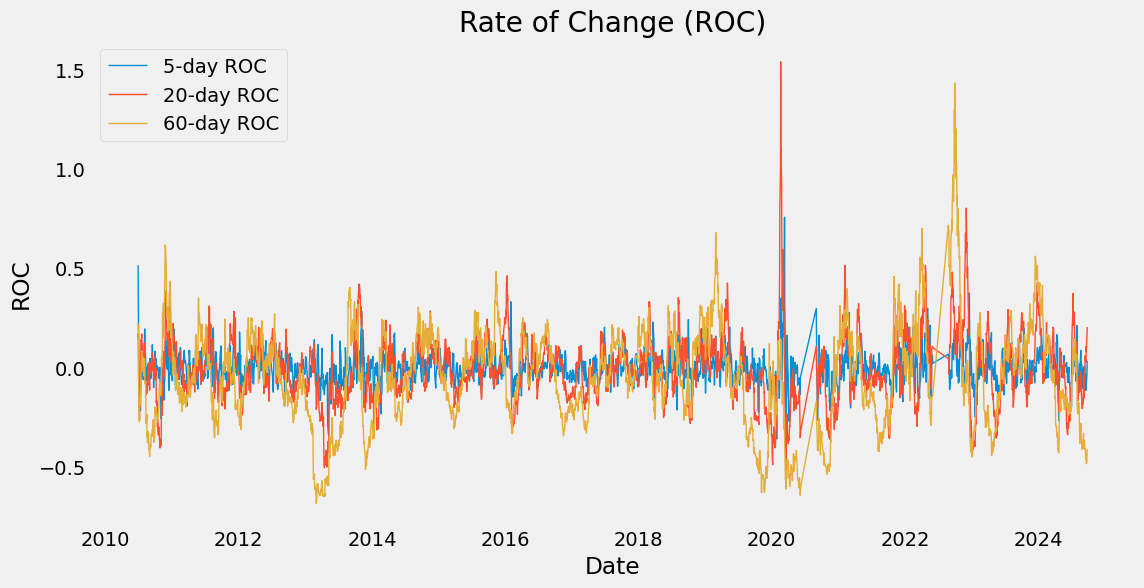

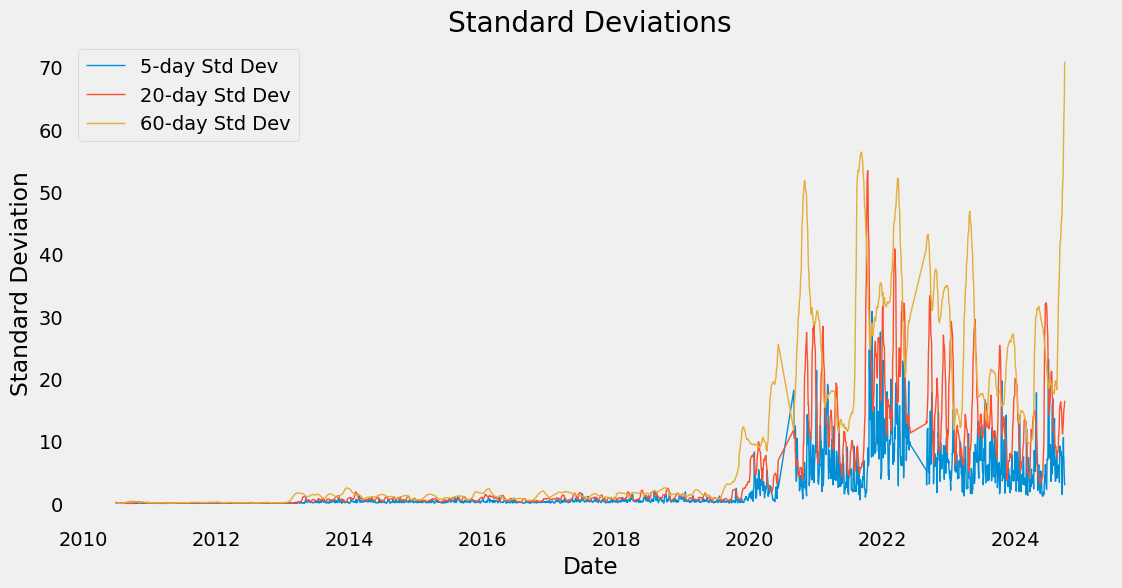

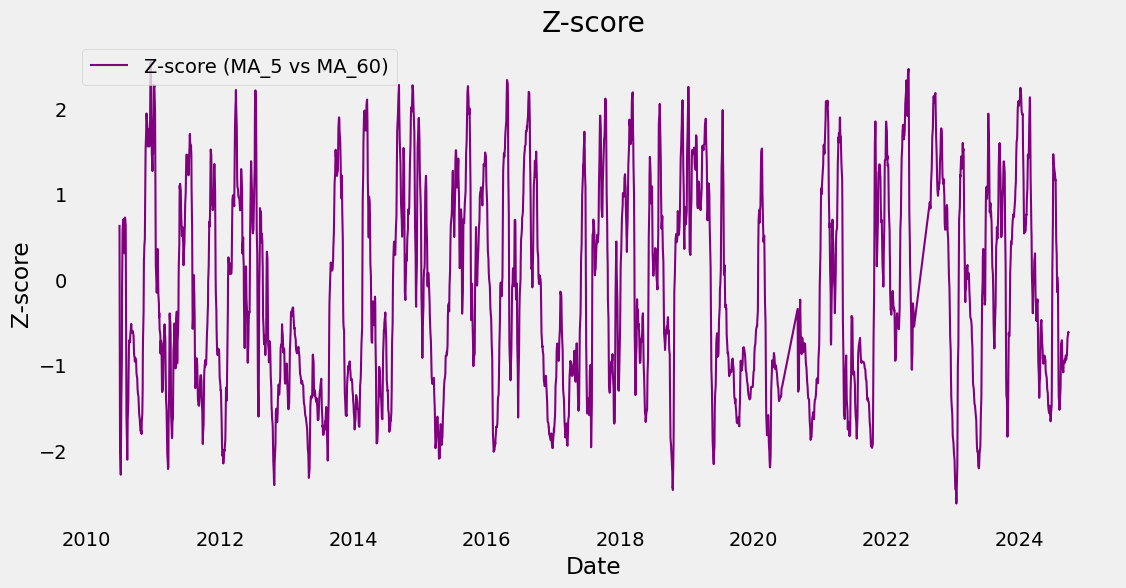

In [6]:
def FeatureEngineering(df):

    # Feature Engineering
    df['Ratio_MA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['Ratio_MA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['Ratio_MA_60'] = df['Adj Close'].rolling(window=60).mean()
    df['ROC_5'] = df['Adj Close'].pct_change(periods=5)
    df['ROC_20'] = df['Adj Close'].pct_change(periods=20)
    df['ROC_60'] = df['Adj Close'].pct_change(periods=60)
    df['Lag_1'] = df['Adj Close'].shift(1)
    df['Lag_5'] = df['Adj Close'].shift(5)
    df['Lag_20'] = df['Adj Close'].shift(20)
    df['std_5'] = df['Adj Close'].rolling(window=5 , center=False).std()
    df['std_20'] = df['Adj Close'].rolling(window=20 , center=False).std()
    df['std_60'] = df['Adj Close'].rolling(window=60 , center=False).std()
    df['zscore_60_5'] = (df['Ratio_MA_5'] - df['Ratio_MA_60'])/df['std_60']

    df = df.dropna()

    import matplotlib.pyplot as plt

    # Ensure DateTime index for better plotting
    df['Date'] = pd.to_datetime(df.index)  # Adjust if index is not already DateTime
    df.set_index('Date', inplace=True)

    # Plot Moving Averages
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Adj Close'], label='Adjusted Close', alpha=0.8, linewidth=2)
    plt.plot(df.index, df['Ratio_MA_5'], label='5-day MA', linewidth=1.5)
    plt.plot(df.index, df['Ratio_MA_20'], label='20-day MA',  linewidth=1.5)
    plt.plot(df.index, df['Ratio_MA_60'], label='60-day MA', linewidth=1.5)
    plt.title('Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Rate of Change
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['ROC_5'], label='5-day ROC',  linewidth=1)
    plt.plot(df.index, df['ROC_20'], label='20-day ROC', linewidth=1)
    plt.plot(df.index, df['ROC_60'], label='60-day ROC', linewidth=1)
    plt.title('Rate of Change (ROC)')
    plt.xlabel('Date')
    plt.ylabel('ROC')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Standard Deviations
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['std_5'], label='5-day Std Dev', linewidth=1)
    plt.plot(df.index, df['std_20'], label='20-day Std Dev',  linewidth=1)
    plt.plot(df.index, df['std_60'], label='60-day Std Dev',  linewidth=1)
    plt.title('Standard Deviations')
    plt.xlabel('Date')
    plt.ylabel('Standard Deviation')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Z-scores
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['zscore_60_5'], label='Z-score (MA_5 vs MA_60)', color='purple', linewidth=1.5)
    plt.title('Z-score')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.legend()
    plt.grid()
    plt.show()


    df.head(10)
    
    return df

df = FeatureEngineering(df)


C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_5'] = df['Adj Close'].pct_change(periods=5)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_20'] = df['Adj Close'].pct_change(periods=20)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_me

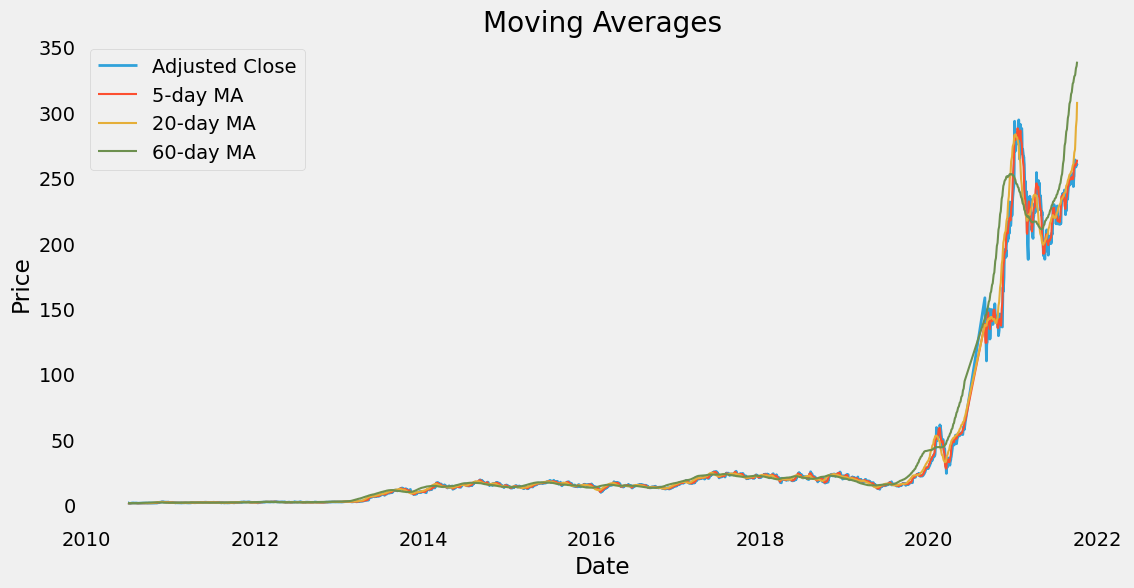

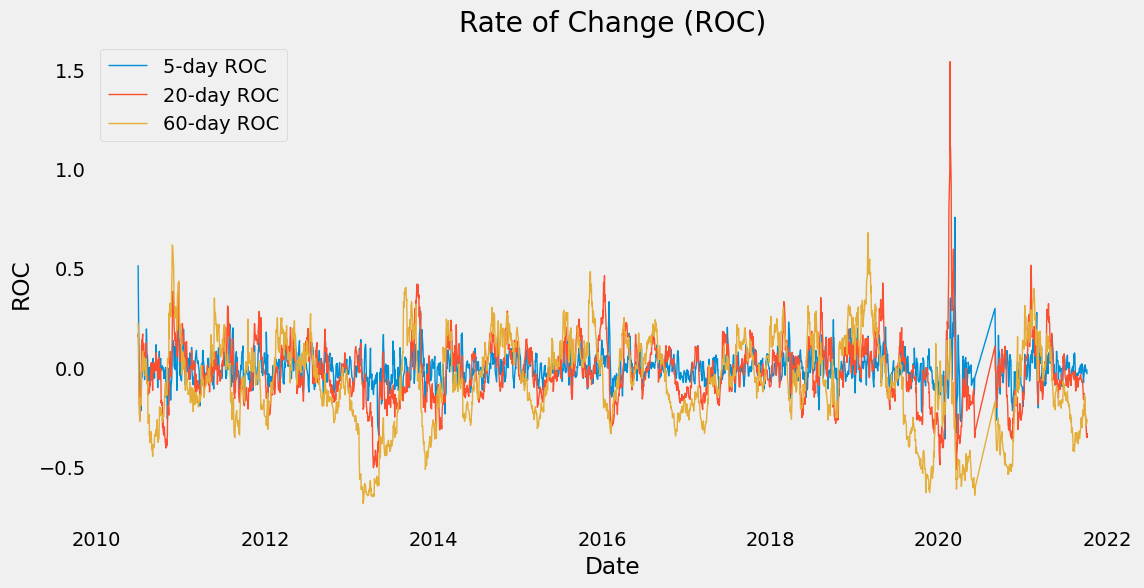

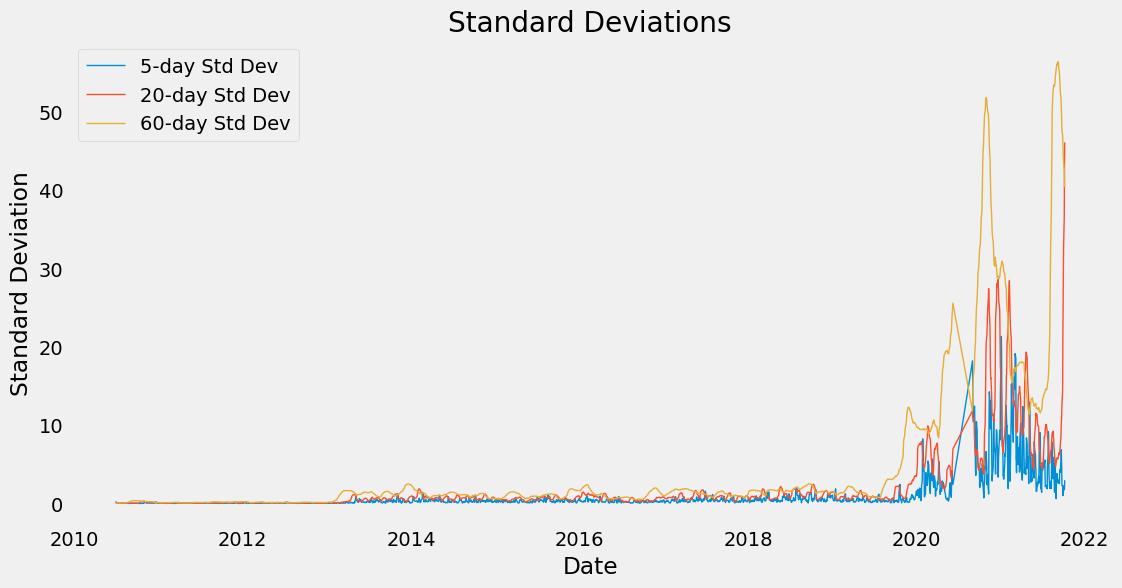

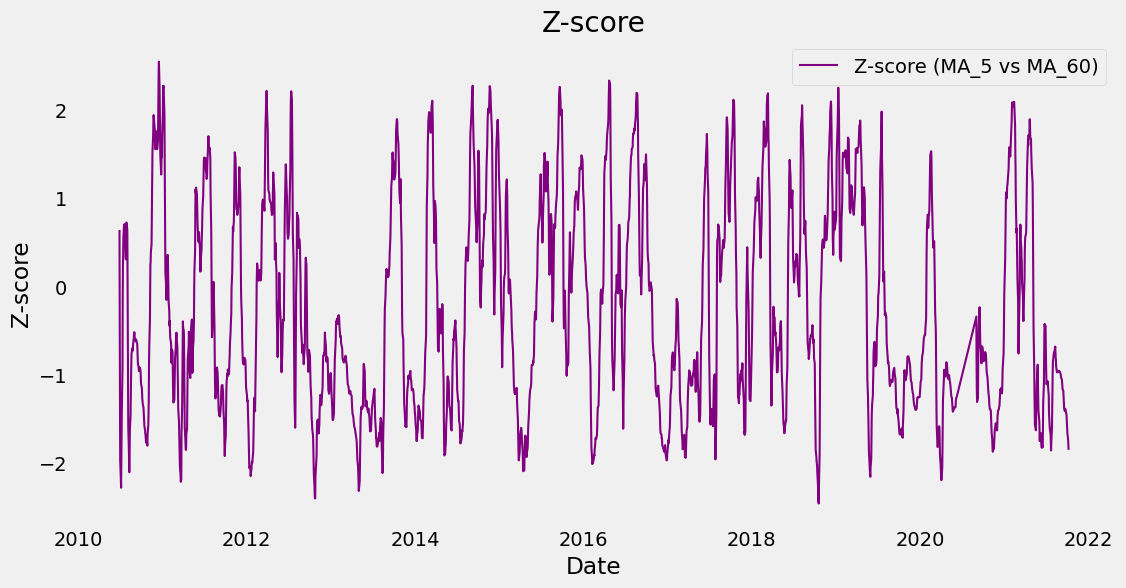

C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_5'] = df['Adj Close'].pct_change(periods=5)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:8: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ROC_20'] = df['Adj Close'].pct_change(periods=20)
C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\643093993.py:9: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_me

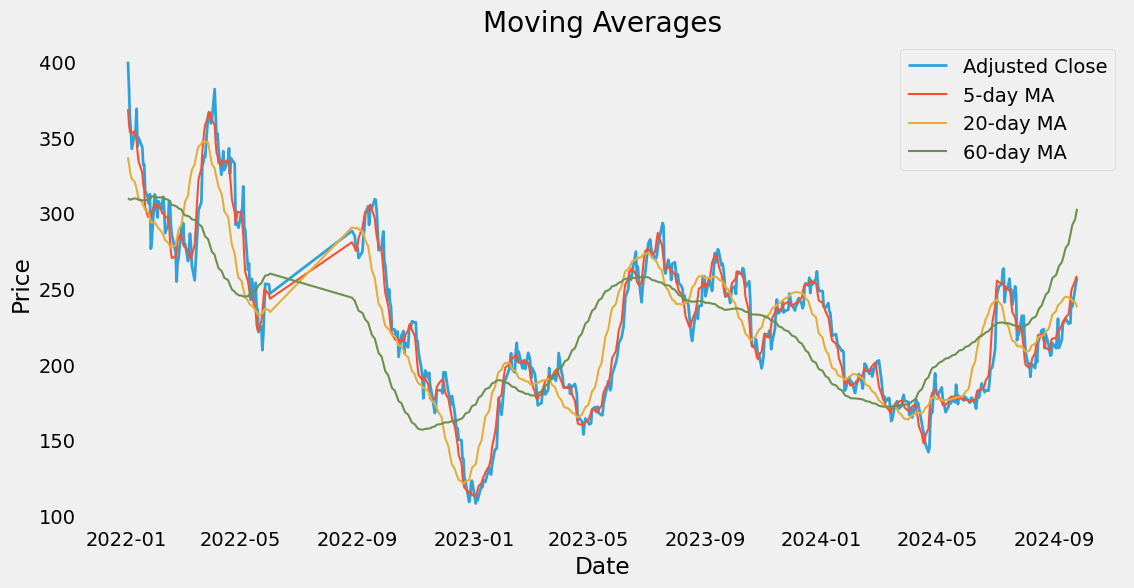

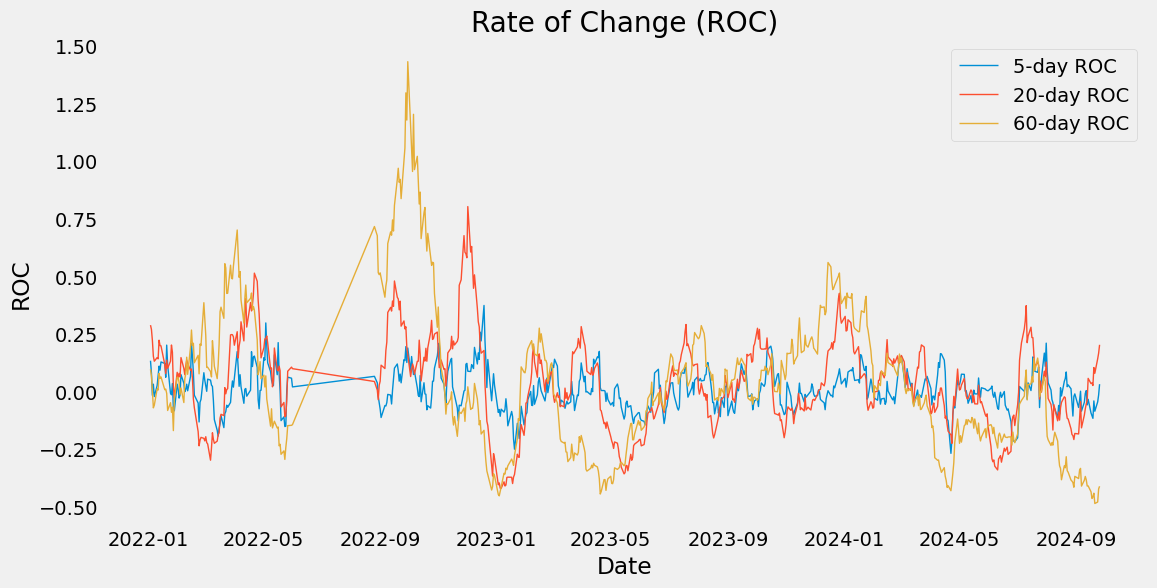

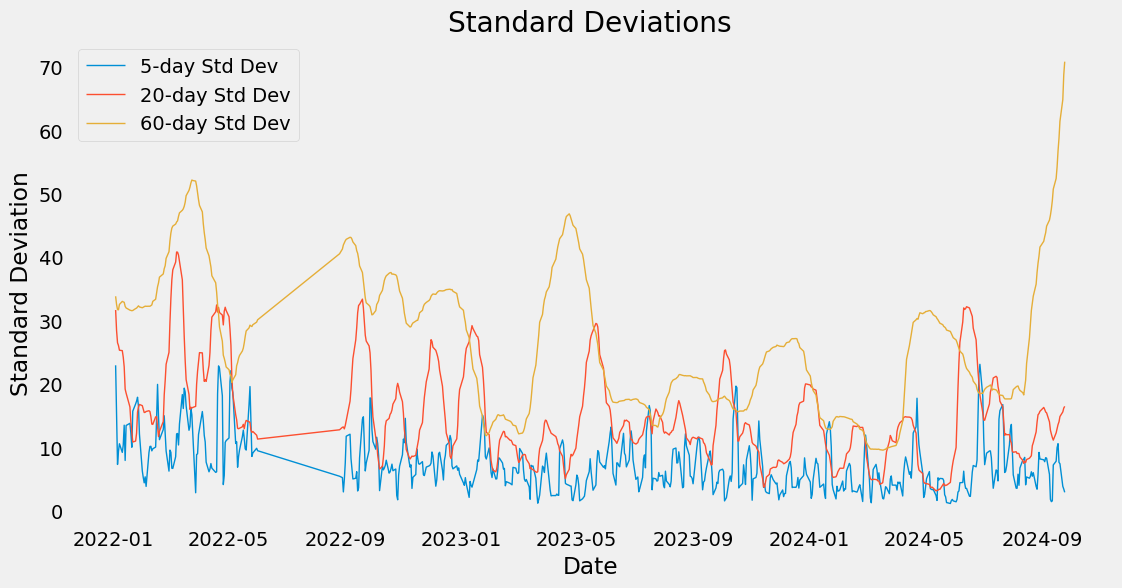

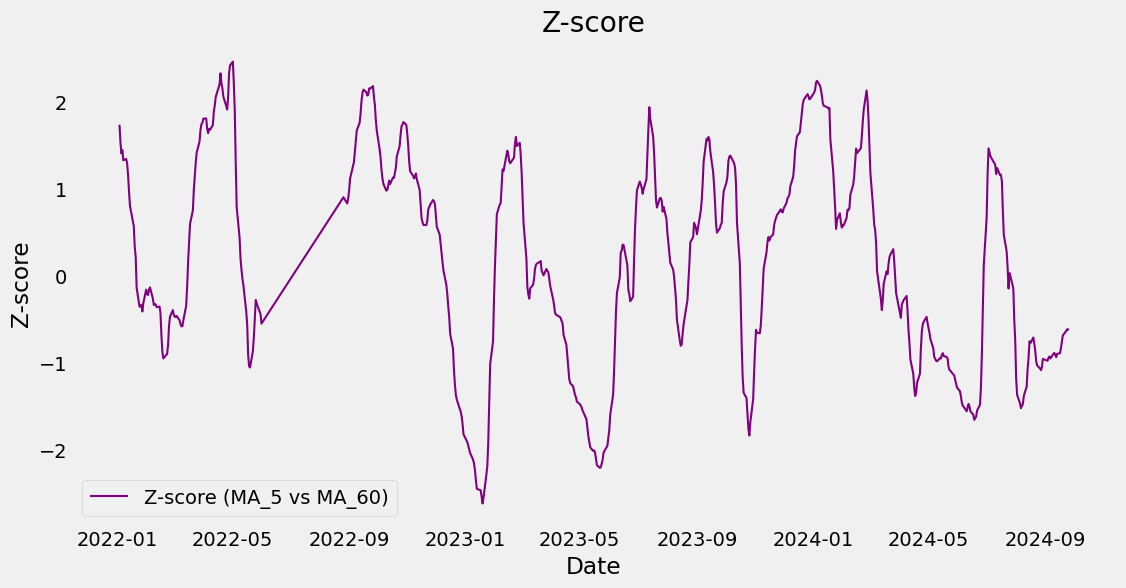

In [7]:
train = FeatureEngineering(train)
test = FeatureEngineering(test)

FEATURES = ['Ratio_MA_5','Ratio_MA_20','Ratio_MA_60','ROC_5','ROC_20','ROC_60','Lag_1','Lag_5','Lag_20','std_5','std_20','std_60','zscore_60_5']
TARGET = ['Adj Close']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [8]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:69.49274	validation_1-rmse:229.79951
[100]	validation_0-rmse:26.06534	validation_1-rmse:95.45296
[200]	validation_0-rmse:9.98911	validation_1-rmse:46.19534


c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:4.17061	validation_1-rmse:29.36689
[400]	validation_0-rmse:2.20305	validation_1-rmse:23.50839
[500]	validation_0-rmse:1.63621	validation_1-rmse:21.43550
[600]	validation_0-rmse:1.42599	validation_1-rmse:20.58677
[700]	validation_0-rmse:1.31583	validation_1-rmse:20.08792
[800]	validation_0-rmse:1.22674	validation_1-rmse:19.82358
[900]	validation_0-rmse:1.16199	validation_1-rmse:19.65088
[999]	validation_0-rmse:1.10172	validation_1-rmse:19.53252


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

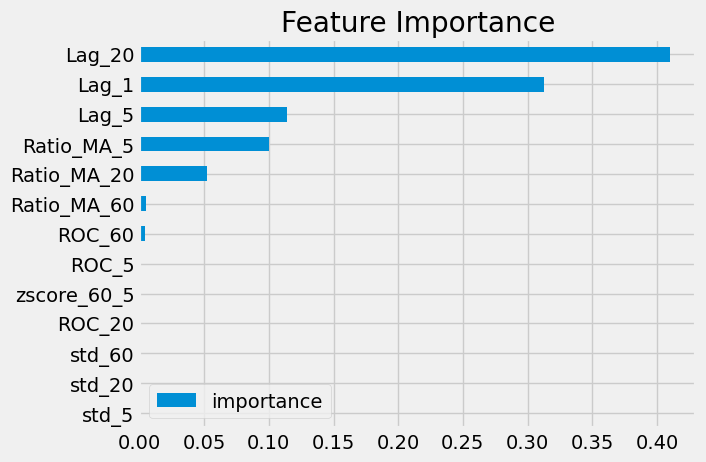

In [9]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

C:\Users\jayes\AppData\Local\Temp\ipykernel_9528\3119348973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


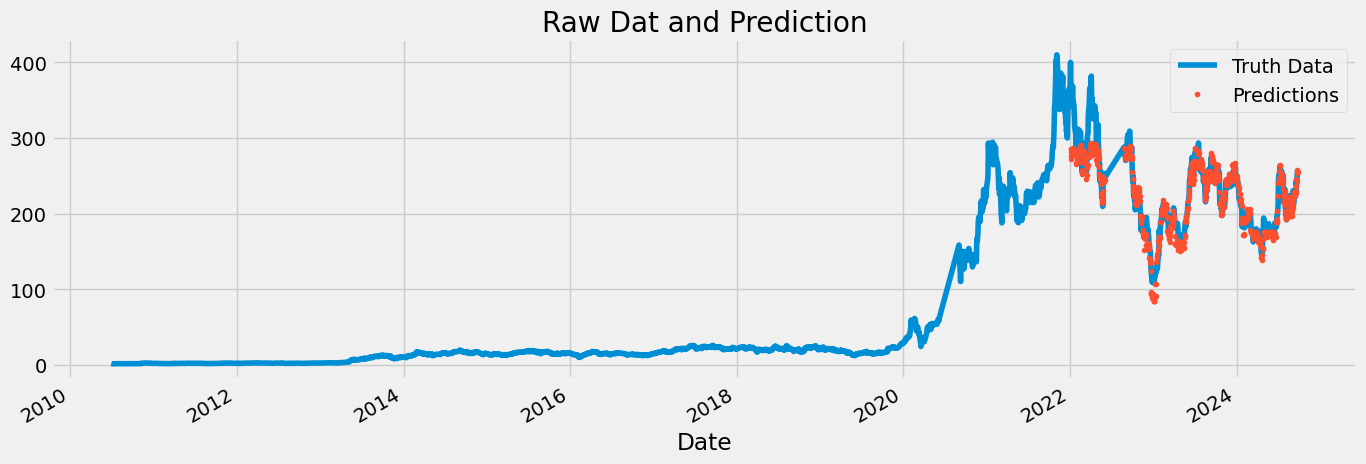

In [10]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Adj Close']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

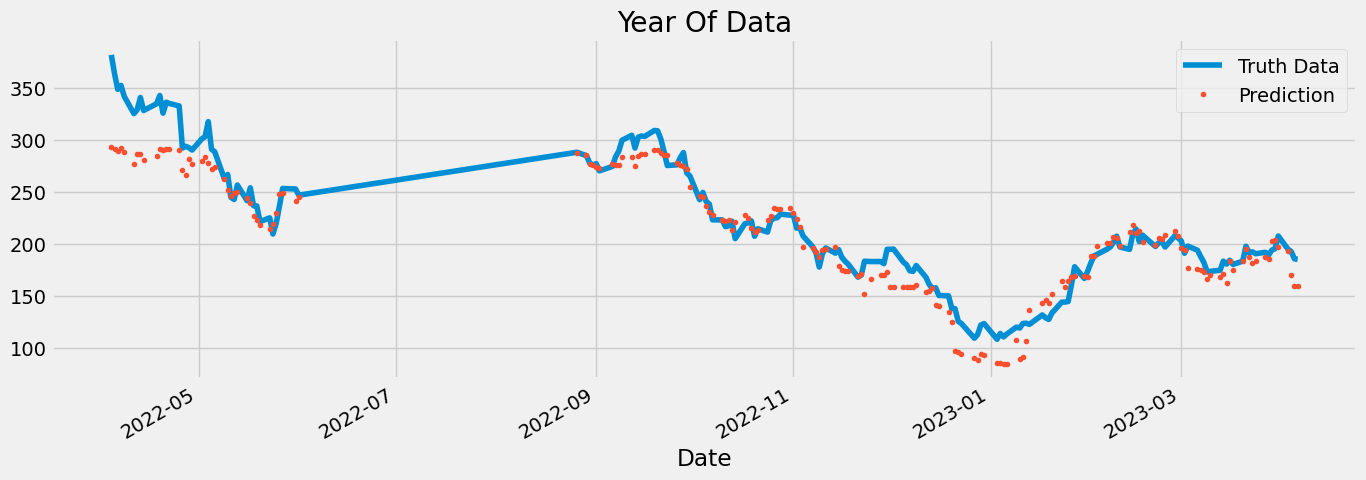

In [11]:
ax = df.loc[(df.index > '04-01-2022') & (df.index < '04-08-2023')]['Adj Close'] \
    .plot(figsize=(15, 5), title='Year Of Data')
df.loc[(df.index > '04-01-2022') & (df.index < '04-08-2023')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [12]:
score = np.sqrt(mean_squared_error(test['Adj Close'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 19.53


In [13]:
from sklearn.metrics import r2_score
r2 = r2_score(test['Adj Close'], test['prediction'])
print(f'r2 Score on Test set: {r2:0.2f}')

#Measures how well the model explains the variability of the target variable. Value ranges from 0 to 1 (or negative if the model performs worse than the baseline).

r2 Score on Test set: 0.87


In [14]:
mape = np.mean(np.abs((test['Adj Close'] - test['prediction']) / test['Adj Close'])) * 100

print(mape)

4.97602683186789


In [15]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test['Adj Close'], test['prediction'])

print(mae)


11.712717945640359
